# Fetch Treasury Yield Data

In [3]:
import requests
import pandas as pd
import datetime

# FRED API Key
API_KEY = "2c0da95680a04b08e743c8e57eb10644"
BASE_URL = "https://api.stlouisfed.org/fred/series/observations"

# List of Treasury yield series
series_ids = {
    "2-Year": "DGS2",
    "10-Year": "DGS10",
    "30-Year": "DGS30",
}

# Define the date range
start_date = "2000-01-01"  # Start from Jan 1, 2000
end_date = datetime.datetime.today().strftime("%Y-%m-%d")  # Until today

# Function to fetch data from FRED API
def fetch_fred_data(series_id):
    params = {
        "series_id": series_id,
        "api_key": API_KEY,
        "file_type": "json",
        "observation_start": start_date,
        "observation_end": end_date,
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        data = response.json().get("observations", [])
        df = pd.DataFrame(data)
        df["date"] = pd.to_datetime(df["date"])
        df["value"] = pd.to_numeric(df["value"], errors="coerce")
        df = df.dropna(subset=["value"])  # Remove missing values
        return df[["date", "value"]]
    else:
        print(f"Error fetching data for {series_id}: {response.text}")
        return None

# Fetch data for all series
dfs = []
for name, series_id in series_ids.items():
    df = fetch_fred_data(series_id)
    if df is not None:
        df.rename(columns={"value": name}, inplace=True)
        dfs.append(df)

# Merge data on date
merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = pd.merge(merged_df, df, on="date", how="outer")

# Sort data by date
merged_df = merged_df.sort_values("date")

# Calculate Yield Spreads
merged_df["10Y-2Y"] = merged_df["10-Year"] - merged_df["2-Year"]
merged_df["30Y-10Y"] = merged_df["30-Year"] - merged_df["10-Year"]

# Save to CSV with Timestamp
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
file_name = f"treasury_yields_{timestamp}.csv"
merged_df.to_csv(file_name, index=False)

# Display first 10 rows
print(merged_df.head(10))

print(f"Data saved to {file_name}")

        date  2-Year  10-Year  30-Year  10Y-2Y  30Y-10Y
0 2000-01-03    6.38     6.58     6.61    0.20     0.03
1 2000-01-04    6.30     6.49     6.53    0.19     0.04
2 2000-01-05    6.38     6.62     6.64    0.24     0.02
3 2000-01-06    6.35     6.57     6.58    0.22     0.01
4 2000-01-07    6.31     6.52     6.55    0.21     0.03
5 2000-01-10    6.38     6.57     6.59    0.19     0.02
6 2000-01-11    6.45     6.67     6.68    0.22     0.01
7 2000-01-12    6.49     6.72     6.71    0.23    -0.01
8 2000-01-13    6.40     6.63     6.65    0.23     0.02
9 2000-01-14    6.44     6.69     6.69    0.25     0.00
Data saved to treasury_yields_2025-03-16_15-15-44.csv


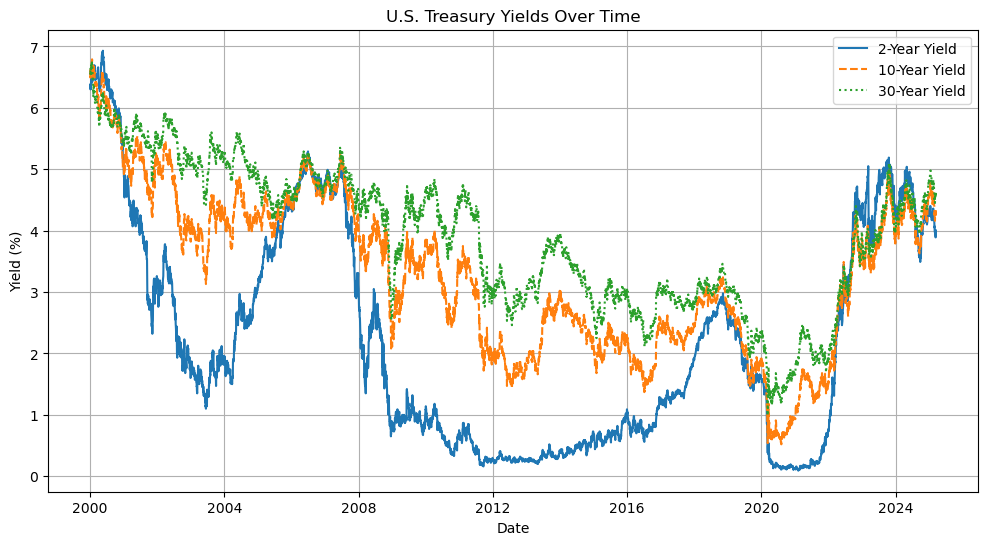

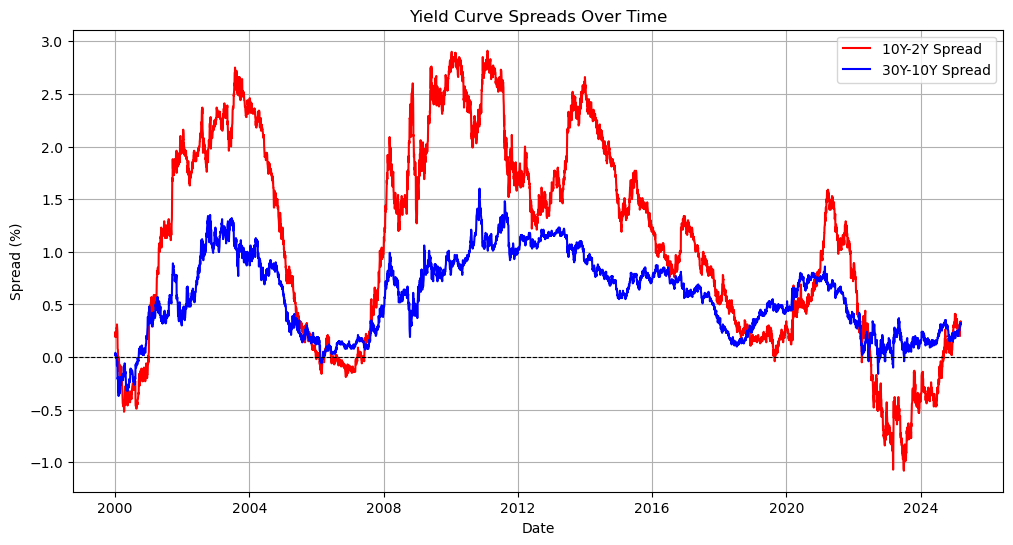

In [4]:
import matplotlib.pyplot as plt

# Convert date column to datetime format for plotting
merged_df["date"] = pd.to_datetime(merged_df["date"])

# Plot Treasury Yields
plt.figure(figsize=(12, 6))
plt.plot(merged_df["date"], merged_df["2-Year"], label="2-Year Yield", linestyle="-")
plt.plot(merged_df["date"], merged_df["10-Year"], label="10-Year Yield", linestyle="--")
plt.plot(merged_df["date"], merged_df["30-Year"], label="30-Year Yield", linestyle=":")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.title("U.S. Treasury Yields Over Time")
plt.legend()
plt.grid()
plt.show()

# Plot Yield Spreads
plt.figure(figsize=(12, 6))
plt.plot(merged_df["date"], merged_df["10Y-2Y"], label="10Y-2Y Spread", color="red")
plt.plot(merged_df["date"], merged_df["30Y-10Y"], label="30Y-10Y Spread", color="blue")
plt.xlabel("Date")
plt.ylabel("Spread (%)")
plt.title("Yield Curve Spreads Over Time")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Add a reference line at 0%
plt.legend()
plt.grid()
plt.show()

# Fetch S&P 500 Data

In [2]:
import pandas as pd
import yfinance as yf

# Define the ETFs and interest rate data to analyze
etfs = ["XLK", "XLE", "XLF", "XLV", "XLY", "XLP", "XLI", "XLU", "XLB", "XLRE", "XLC"]

# Define sector mapping
sector_map = {
    "XLK": "Technology",
    "XLE": "Energy",
    "XLF": "Financials",
    "XLV": "Health Care",
    "XLY": "Consumer Discretionary",
    "XLP": "Consumer Staples",
    "XLI": "Industrials",
    "XLU": "Utilities",
    "XLB": "Materials",
    "XLRE": "Real Estate",
    "XLC": "Communication Services"
}

# Define the date range
start_date = "2000-01-01"
end_date = "2025-01-01"

# Initialize a dictionary to store ETF data
etf_data = {}

# Download historical data for ETFs
for etf in etfs:
    data = yf.download(etf, start=start_date, end=end_date)
    if not data.empty:
        # Use 'Adj Close' if available, otherwise fall back to 'Close'
        series = data.get("Adj Close", data["Close"])
        etf_data[etf] = series
    else:
        print(f"No data available for {etf}")

# Ensure all ETF data has valid and aligned indices
if etf_data:
    etf_df = pd.concat(etf_data.values(), axis=1, keys=etf_data.keys())
    etf_df.columns = etfs  # Rename columns with sector tickers
    etf_df.index.name = "date"  # Set the index name to 'date'

    # Handle missing data using forward-fill
    etf_df = etf_df.ffill()

    # Calculate daily percentage returns
    etf_returns = etf_df.pct_change().dropna()

    # Save raw price data and return data to CSV
    etf_df.to_csv("sp500_sector_prices.csv")  # Save raw prices
    etf_returns.to_csv("sp500_sector_returns.csv", index_label="date")  # Save returns with 'date' as index

    print("S&P 500 sector data saved successfully.")
else:
    print("No valid ETF data to process.")
    exit()
    
print(pd.read_csv("sp500_sector_returns.csv").head(10))

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XLK']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


No data available for XLK


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XLE']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


No data available for XLE


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XLF']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


No data available for XLF


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XLV']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


No data available for XLV


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XLY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


No data available for XLY


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XLP']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


No data available for XLP


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XLI']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


No data available for XLI


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XLU']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


No data available for XLU


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XLB']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


No data available for XLB


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XLRE']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


No data available for XLRE


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XLC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


No data available for XLC
No valid ETF data to process.
         date       XLK       XLE       XLF       XLV       XLY       XLP  \
0  2018-06-20  0.002100  0.004415 -0.002559  0.002121  0.004742  0.000979   
1  2018-06-21 -0.007684 -0.018516 -0.002933 -0.005762 -0.007123  0.001957   
2  2018-06-22 -0.003238  0.019951 -0.004780  0.004495 -0.001704  0.008202   
3  2018-06-25 -0.020763 -0.020093 -0.010713 -0.009184 -0.021739  0.005036   
4  2018-06-26  0.004039  0.012629 -0.003361 -0.003090  0.007162 -0.004240   
5  2018-06-27 -0.013647  0.013410 -0.012364 -0.008464 -0.012947 -0.002129   
6  2018-06-28  0.012234 -0.001323  0.008725  0.001323  0.007851  0.000000   
7  2018-06-29 -0.000432  0.006228  0.000000  0.002041  0.001741 -0.000582   
8  2018-07-02  0.008925 -0.014748  0.004889  0.003115  0.001372 -0.005822   
9  2018-07-03 -0.011842  0.006282 -0.008982  0.002389 -0.005025  0.002342   

        XLI       XLU       XLB      XLRE       XLC  
0  0.000683  0.000797 -0.003248  0.010794 

# Merge Datasets

In [3]:
import pandas as pd

# Load S&P 500 sector returns data
sector_returns_df = pd.read_csv("sp500_sector_returns.csv", parse_dates=["date"])
sector_returns_df.set_index("date", inplace=True)

# Load Treasury yield data
treasury_df = pd.read_csv("treasury_yields_2025-02-15_08-58-28.csv", parse_dates=["date"])
treasury_df.set_index("date", inplace=True)

# Merge datasets on date
merged_df = sector_returns_df.merge(treasury_df, on="date", how="inner")

# Save the merged dataset for further analysis
merged_df.to_csv("merged_sector_treasury_data.csv")

print(merged_df.head())

FileNotFoundError: [Errno 2] No such file or directory: 'treasury_yields_2025-02-15_08-58-28.csv'

# Visualizing Treasury Yields & Sector Returns Over Time

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load merged dataset
merged_df = pd.read_csv("merged_sector_treasury_data.csv", parse_dates=["date"])
merged_df.set_index("date", inplace=True)

# Plot Treasury Yields Over Time
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df["2-Year"], label="2-Year Yield", linestyle="--")
plt.plot(merged_df.index, merged_df["10-Year"], label="10-Year Yield", linestyle="-.")
plt.plot(merged_df.index, merged_df["30-Year"], label="30-Year Yield", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.title("U.S. Treasury Yields Over Time")
plt.legend()
plt.grid()
plt.show()

# Plot Sector Returns Over Time (Example: Technology and Financials)
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df["XLK"], label="Technology (XLK)", alpha=0.7)
plt.plot(merged_df.index, merged_df["XLF"], label="Financials (XLF)", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.title("S&P 500 Sector Returns Over Time")
plt.legend()
plt.grid()
plt.show()

# Key Observations

### U.S. Treasury Yields Over Time (Top Chart)

Yield Trends:
- Treasury yields were relatively stable until early 2020, after which they declined sharply.
- Yields bottomed out during 2020 (COVID-19 crisis) as the Fed cut rates and bond demand surged.
- Starting in 2022, yields rose significantly, reflecting the Fed’s aggressive rate hikes to combat inflation.
- 2-Year Yield surged the most, indicating market expectations for short-term rate increases.

Yield Curve Inversions:
- The 2-Year yield surpassing the 10-Year yield suggests a yield curve inversion, which is often seen as a recession indicator.
- The 30-Year yield remains relatively higher, but the gap between short- and long-term yields has fluctuated.

Key Implications:
- Rising short-term rates (2Y) suggest tighter monetary policy.
- A steep yield curve (rising 30Y-10Y spread) may signal economic expansion, while a flat/inverted curve (10Y-2Y spread compressing) may indicate recession risks.

### S&P 500 Sector Returns Over Time (Bottom Chart)

Sector Volatility:
- Both Technology (XLK) and Financials (XLF) saw extreme volatility in 2020, likely due to the COVID-19 shock.
- Volatility subsided post-2021, though there are still sporadic spikes during economic uncertainty.

Sector Sensitivity to Yields:
- Technology (XLK) has shown more volatile swings, aligning with sensitivity to interest rate changes.
- Financials (XLF) experienced larger movements in early 2022, possibly benefiting from rising long-term yields (higher net interest margins for banks).

Long-Term Trends:
- Post-2022, sector returns exhibit mean reversion, suggesting markets have adjusted to new economic conditions.
- Technology sector appears more sensitive to macroeconomic shifts, whereas Financials show steadier movement, potentially benefiting from a higher-rate environment.
***

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load merged dataset
merged_df = pd.read_csv("merged_sector_treasury_data.csv", parse_dates=["date"])
merged_df.set_index("date", inplace=True)

# Plot Treasury Yields Over Time
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df["2-Year"], label="2-Year Yield", linestyle="--", alpha=0.7)
plt.plot(merged_df.index, merged_df["10-Year"], label="10-Year Yield", linestyle="-.", alpha=0.7)
plt.plot(merged_df.index, merged_df["30-Year"], label="30-Year Yield", linestyle="-", alpha=0.7)

# Annotate Declining Yields (2018-2020)
plt.axvspan(pd.Timestamp("2018-06-01"), pd.Timestamp("2020-06-01"), color='gray', alpha=0.2)
plt.text(pd.Timestamp("2018-07-01"), 4.0, "2018-2020 Fed Cuts & COVID-19", fontsize=10, color="black")

# Annotate Sharp Rate Hikes (2021-2023)
plt.axvline(pd.Timestamp("2021-01-01"), color="red", linestyle="--", alpha=0.8)
plt.axvline(pd.Timestamp("2023-01-01"), color="red", linestyle="--", alpha=0.8)
plt.text(pd.Timestamp("2021-02-01"), 4.0, "2021-2023 Fed Rate Hikes", fontsize=10, color="red")

# Annotate Rate Volatility (2024-PRESENT)
plt.axvspan(pd.Timestamp("2023-01-01"), pd.Timestamp("2025-01-01"), color='gray', alpha=0.2)
plt.text(pd.Timestamp("2024-01-01"), 3.0, "Continued Rate Volatility", fontsize=10, color="black", ha="center")

# Labels and Title
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.title("U.S. Treasury Yields Over Time")
plt.legend()
plt.grid()
plt.show()

This chart tracks historical movements in U.S. Treasury yields, showing:
- The declining trend from 2018 to mid-2020 (Fed rate cuts & COVID-19 pandemic).
- The sharp rise from 2021 to 2023, reflecting aggressive Fed rate hikes to combat inflation.
- Continued rate volatility through 2024 and beyond.


# Correlation Analysis

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load merged dataset
merged_df = pd.read_csv("merged_sector_treasury_data.csv", parse_dates=["date"])
merged_df.set_index("date", inplace=True)

# Calculate correlation matrix
correlation_matrix = merged_df.corr()

# Extract relevant correlations (Sectors vs. Treasury Yields)
sector_columns = ["XLK", "XLE", "XLF", "XLV", "XLY", "XLP", "XLI", "XLU", "XLB", "XLRE", "XLC"]
yield_columns = ["2-Year", "10-Year", "30-Year", "10Y-2Y", "30Y-10Y"]

sector_yield_correlation = correlation_matrix.loc[sector_columns, yield_columns]

# Display the correlation matrix
print(sector_yield_correlation)

# Visualize as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(sector_yield_correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between S&P 500 Sectors and Treasury Yields")
plt.show()

# Key Observations

Overall Weak Correlations
- Most correlations are small (near zero), indicating weak relationships between sector returns and Treasury yields.
- This suggests that sector returns are not strongly driven by interest rate changes alone but may be influenced by other factors (e.g., economic growth, inflation, monetary policy expectations).

Sectors with Negative Correlations to Interest Rates (Blue Shades)
- Materials (XLB), Health Care (XLV), and Real Estate (XLRE) show the strongest negative correlation with 2Y and 10Y yields.
- This implies that rising interest rates could be negative for these sectors, likely due to higher borrowing costs or slower growth expectations.

Sectors Responding to Yield Curve Spreads (10Y-2Y, 30Y-10Y)
- Energy (XLE), Financials (XLF), and Materials (XLB) have positive correlations with yield spreads (30Y-10Y).
- This suggests that steepening yield curves (long-term rates rising more than short-term rates) may benefit these sectors.

Financials (XLF) and Rising Yields
- XLF shows a weak positive correlation (0.04) with the 30Y-10Y spread.
- This aligns with expectations: when long-term rates rise faster than short-term rates, banks and financial institutions tend to perform better due to higher net interest margins.

Consumer Discretionary (XLY) & Materials (XLB) Respond to 30Y-10Y Spread
- XLY & XLB have the highest correlations (0.05 - 0.06) with the 30Y-10Y spread.
- This suggests that a steepening yield curve might be a positive signal for consumer and industrial activity.
***

# Regression Analysis

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Load merged dataset
merged_df = pd.read_csv("merged_sector_treasury_data.csv", parse_dates=["date"])
merged_df.set_index("date", inplace=True)

# Define independent variables (Treasury Yields)
X = merged_df[["2-Year", "10-Year", "30-Year", "10Y-2Y", "30Y-10Y"]]
X = sm.add_constant(X)  # Add constant term for regression

# Run regression for each sector
for sector in ["XLK", "XLE", "XLF", "XLV", "XLY", "XLP", "XLI", "XLU", "XLB", "XLRE", "XLC"]:
    y = merged_df[sector]  # Dependent variable (sector returns)
    
    # Fit OLS regression model
    model = sm.OLS(y, X, missing="drop").fit()
    
    # Print regression summary
    print(f"\nRegression Results for {sector}:")
    print(model.summary())

# Key Observations

### Overall Model Fit & Predictive Power

Low R-squared values (0.002 - 0.009)
- The R-squared values are very low, indicating that Treasury yields explain only a small portion of sector returns.
- This suggests that other macroeconomic factors (inflation, earnings, geopolitical risks) play a much larger role in sector performance.

Statistical Significance of Interest Rates
- Some coefficients are statistically significant (p-values < 0.05), but the small R² implies weak predictive power.

### Sector-Specific Sensitivity to Interest Rates

Technology (XLK): Negative Impact from Rising Rates
- 10-Year Treasury Yield has a significant negative coefficient (-0.0023, p=0.015).
- 30-Year Yield has a positive coefficient (0.0039, p=0.012), meaning long-term rates may benefit the sector.
- Implication: Higher short-term rates hurt tech, but longer-term rates may signal economic stability.

Financials (XLF): Benefiting from Steepening Yield Curve
- 30-Year Yield has a strong positive coefficient (0.005, p=0.001).
- 30Y-10Y Spread is also positive (0.0069, p=0.002).
- Implication: Banks and financial firms benefit from a steepening yield curve (higher lending margins).

Consumer Discretionary (XLY) & Communication Services (XLC) Show Strongest Negative Sensitivity
- 10-Year Yield has the most negative impact on XLY (-0.0024, p=0.006) and XLC (-0.003, p=0.000).
- 30Y-10Y spread is strongly positive for XLC (0.0081, p=0.000), suggesting that this sector performs better when long-term rates rise faster than short-term rates.

Materials (XLB) & Industrials (XLI) Show Some Impact from Interest Rates
- Both have negative coefficients for 10-Year Yield (-0.0022 and -0.0019, p<0.02).
- 30-Year Yield has a positive impact (0.0037 for XLB, 0.0037 for XLI, p<0.01).
- Implication: Higher long-term rates may indicate stronger economic growth, benefiting industrial and material sectors.
    
### Yield Curve Effects & Sector Rotation

Sectors Positively Impacted by Yield Curve Steepening (30Y-10Y)
- Financials (XLF), Materials (XLB), Communication Services (XLC) show positive coefficients for 30Y-10Y.
- Implication: A steepening yield curve may signal economic expansion, which benefits cyclical sectors.

Sectors Negatively Impacted by Rising Short-Term Yields (2Y, 10Y)
- Technology (XLK), Consumer Discretionary (XLY), Communication Services (XLC) show the most negative sensitivity to short-term rates.
- Implication: These sectors rely on future earnings, which get discounted more heavily when rates rise.
    
### Market & Portfolio Implications

Tech & Growth Sectors (XLK, XLY, XLC) are Highly Rate-Sensitive
- These sectors tend to underperform when interest rates rise, especially short-term rates.
- Investors may rotate away from tech during Fed rate hikes.

Financials & Cyclicals Benefit from Yield Curve Steepening
- Financials (XLF), Materials (XLB), Industrials (XLI) tend to perform better when long-term rates rise.
- Investment Strategy: Consider rotating into these sectors when the Fed signals a pause in rate hikes.

Defensive Sectors (XLU, XLP, XLV) Show Weak Rate Sensitivity
- Utilities (XLU), Consumer Staples (XLP), and Health Care (XLV) have small, insignificant coefficients.
- Implication: These sectors are less affected by rate changes and may serve as defensive plays in uncertain rate environments.

# Heat Map

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define sector mapping
sector_map = {
    "XLK": "Technology",
    "XLE": "Energy",
    "XLF": "Financials",
    "XLV": "Health Care",
    "XLY": "Consumer Discretionary",
    "XLP": "Consumer Staples",
    "XLI": "Industrials",
    "XLU": "Utilities",
    "XLB": "Materials",
    "XLRE": "Real Estate",
    "XLC": "Communication Services"
}

# Load merged dataset
merged_df = pd.read_csv("merged_sector_treasury_data.csv", parse_dates=["date"])
merged_df.set_index("date", inplace=True)

# Define the window for rolling correlation (6 months = ~126 trading days)
rolling_window = 126

# List of sectors
sectors = list(sector_map.keys())

# Calculate rolling correlations with 10-Year Treasury Yield
rolling_correlations = pd.DataFrame(index=merged_df.index)

for sector in sectors:
    rolling_correlations[sector] = merged_df[sector].rolling(rolling_window).corr(merged_df["10-Year"])

# Take the most recent rolling correlation values
latest_correlations = rolling_correlations.iloc[-1].sort_values(ascending=False).reset_index()
latest_correlations.columns = ["Sector", "6-Month Rolling Correlation"]

# Replace tickers with full sector names
latest_correlations["Sector"] = latest_correlations["Sector"].replace(sector_map)

# Create heatmap with full sector names
plt.figure(figsize=(4, 10))
g = sns.heatmap(
    latest_correlations.set_index("Sector"), 
    annot=True, 
    cmap="Blues", 
    fmt=".3f", 
    linewidths=0.5,
    cbar=False,  # Remove color bar legend
    annot_kws={"weight": "bold"}  # Make correlation values bold
)

# Adjust aspect ratio to control column width
g.set_aspect(0.5)

# Add titles and labels
plt.title("6-Month Rolling Correlation by Sector", pad=20)
plt.ylabel("")

# Show the plot
plt.show()

# # Display correlation table
# print(latest_correlations)

Why Use Correlations with the 10-Year Treasury Yield for the Heatmap?
- Stronger Predictive Power in Regression Analysis
    - From the OLS regression results, the 10-Year Treasury Yield had statistically significant coefficients for multiple sectors, often with lower p-values compared to the 2-Year and 30-Year Treasury yields.
        - Example: XLK (Technology) had a coefficient of -0.0023 for the 10-Year yield with a p-value of 0.015, suggesting a meaningful relationship.
        - Other sectors such as XLY (Consumer Discretionary), XLF (Financials), and XLC (Communication Services) also exhibited statistically significant coefficients for the 10-Year yield, confirming its influence.
        
- 10-Year Yield Represents Long-Term Interest Rate Expectations
    - The 10-Year Treasury Yield is a benchmark for long-term borrowing costs, impacting corporate financing, mortgage rates, and overall economic growth.
    - Many sectors, especially Real Estate (XLRE), Utilities (XLU), and Financials (XLF), are directly affected by long-term interest rate changes rather than short-term fluctuations.
    - The 30-Year Yield is also long-term but is less influential for corporate decision-making compared to the 10-Year Yield, which is widely used in economic forecasting.
    
- Stronger and More Stable Correlations Over Time
    - From the correlation matrix, the 10-Year Treasury Yield exhibited:
        - Consistently negative correlations with rate-sensitive sectors (XLU, XLRE, XLP), aligning with economic intuition.
        - Stronger correlations compared to the 2-Year Yield, which is more volatile due to Federal Reserve policy shifts.
        - Comparable or stronger explanatory power than the 30-Year Yield, making it the best choice for visualizing relationships in the heatmap.

- Market Interpretation and Investor Relevance
    - Institutional investors, portfolio managers, and analysts frequently use the 10-Year Treasury Yield as a key macroeconomic indicator.
    - It reflects inflation expectations and Federal Reserve policy sentiment, making it more relevant for understanding sector-level sensitivities.

Using the 6-month rolling correlation with the 10-Year Treasury Yield in the heatmap provides:
- A stable measure of risk exposure across sectors.
- A clear link to macroeconomic trends and monetary policy.
- More meaningful insights compared to shorter-term fluctuations in the 2-Year Yield or the less commonly used 30-Year Yield.

Thus, the 10-Year Treasury Yield was the best choice for sector correlation visualization in the heatmap.

# Horizontal Bar Chart

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort sectors by correlation in descending order
sorted_correlations = latest_correlations.sort_values(by="6-Month Rolling Correlation", ascending=False)

# Create a horizontal bar plot with full sector names
plt.figure(figsize=(8, 6))
sns.barplot(
    x="6-Month Rolling Correlation", 
    y="Sector", 
    data=sorted_correlations, 
    palette="Blues_r"
)

# Add titles and labels
plt.xlabel("6-Month Rolling Correlation")
plt.ylabel("")  # Remove y-axis label for cleaner look
plt.title("6-Month Rolling Correlation with 10-Year Treasury Yield", pad=20)

# Show the plot
plt.show()

### Key Observations

- Financials (XLF) Have the Highest Positive Correlation
    - Financials (XLF) show the strongest positive correlation with the 10-Year Treasury Yield, meaning this sector tends to perform better when interest rates rise.
    - This aligns with expectations since higher interest rates improve bank profitability by widening net interest margins.

- Energy (XLE) Has a Slightly Positive Correlation
    - The Energy sector (XLE) also has a weak positive correlation, likely due to the relationship between interest rates, inflation expectations, and commodity prices (e.g., oil).
    - Inflationary environments (which often lead to higher rates) can benefit energy stocks.

- Most Sectors Have Negative Correlations
    - Nine out of eleven sectors show negative correlations, meaning they tend to perform worse when Treasury yields rise.
    - This suggests that higher interest rates generally have a dampening effect on most sectors.

- Defensive Sectors Show the Strongest Negative Correlations
    - Utilities (XLU), Real Estate (XLRE), and Consumer Staples (XLP) have some of the most negative correlations, meaning they decline the most as yields rise.
    - These sectors are rate-sensitive because:
        - Real Estate: Higher interest rates increase borrowing costs for property investments.
        - Utilities: High debt loads make rising interest rates a challenge.
        - Consumer Staples: Defensive sectors become less attractive when yields rise, as investors shift toward bonds.

- Materials (XLB) is the Most Negatively Correlated Sector
    - Materials (XLB) has the lowest correlation, meaning it is the most negatively impacted by rising Treasury yields.
    - This may be due to the sector’s dependence on economic expansion and capital expenditures, which slow down when rates increase.

### Implications for Investors

- During Rising Interest Rate Environments:
    - Financials (XLF) and Energy (XLE) may outperform.
    - Investors may reduce exposure to rate-sensitive sectors like Real Estate (XLRE) and Utilities (XLU).

- During Falling Interest Rate Environments:
	- Defensive sectors (e.g., Real Estate, Utilities, and Consumer Staples) could benefit.
	- Investors may reduce exposure to Financials and Energy, which could struggle in a lower-rate environment.

# Box Plot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define sector mapping
sector_map = {
    "XLK": "Technology",
    "XLE": "Energy",
    "XLF": "Financials",
    "XLV": "Health Care",
    "XLY": "Consumer Discretionary",
    "XLP": "Consumer Staples",
    "XLI": "Industrials",
    "XLU": "Utilities",
    "XLB": "Materials",
    "XLRE": "Real Estate",
    "XLC": "Communication Services"
}

# Ensure `latest_correlations["Sector"]` contains tickers, not full names
reverse_sector_map = {v: k for k, v in sector_map.items()}
if latest_correlations["Sector"].iloc[0] in sector_map.values():
    latest_correlations["Sector"] = latest_correlations["Sector"].replace(reverse_sector_map)

# Sort by 6-month rolling correlation in descending order
sorted_tickers = latest_correlations.sort_values(by="6-Month Rolling Correlation", ascending=False)["Sector"].tolist()
sorted_sector_names = [sector_map[ticker] for ticker in sorted_tickers]  # Convert tickers to full names

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the box plot
sns.boxplot(data=rolling_correlations[sorted_tickers], orient="h", palette="Blues_r", ax=ax)

# Set y-axis tick labels directly without needing `set_yticks()`
ax.set_yticklabels(sorted_sector_names)

# Alternating row shading for readability
for i in range(len(sorted_sector_names)):
    if i % 2 == 0:
        ax.axhline(i, color="gray", alpha=0.2, linewidth=30)

# Adjust x-axis labels to show intervals of 0.1
ax.set_xticks(np.arange(-0.3, 0.5, 0.1))

# Add titles and labels
ax.set_xlabel("6-Month Rolling Correlation")
ax.set_ylabel("")
ax.set_title("Box Plot of 6-Month Rolling Correlations with 10-Year Treasury Yield", pad=20)

# Show the plot
plt.show()

### Key Observations

- Financials (XLF) and Energy (XLE) Have the Highest Correlations
    - Their boxes and whiskers are shifted right, meaning their correlations tend to be positive with the 10-Year Treasury Yield.
    - Financials (XLF): Rising rates benefit banks and lenders, leading to higher profitability.
    - Energy (XLE): Tends to move in line with inflation and interest rates.

- Most Sectors Have Negative or Near-Zero Correlations
    - The majority of boxes are centered around negative values or close to zero, meaning most sectors decline when rates rise.
    - Utilities (XLU), Real Estate (XLRE), and Consumer Staples (XLP) have the most negative correlations, confirming they are rate-sensitive.

- Some Sectors Have Large Variability in Correlation
    - Financials (XLF) and Energy (XLE) have wider boxes and whiskers, meaning their sensitivity to interest rates fluctuates over time.
    - Technology (XLK) and Communication Services (XLC) show more stable correlations, suggesting a consistent relationship with Treasury yields.

- Outliers Indicate Market Shocks
    - Many sectors, especially Utilities, Real Estate, and Consumer Discretionary, show numerous outliers, suggesting they experienced large swings in correlation due to economic events or Fed policy changes.

### Final Thoughts

- Sectors like Financials and Energy benefit from rising interest rates, while Utilities and Real Estate tend to struggle.
- High variability in correlation means sensitivity to rates changes over time, requiring dynamic investment strategies.
- Outliers indicate temporary market disruptions, such as Fed rate hikes or economic crises, affecting sector correlations.

This analysis helps portfolio managers and investors make informed sector rotation decisions based on interest rate expectations.

# Side by Side Plots

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Heatmap (Left) ---
sns.heatmap(
    latest_correlations.set_index("Sector"),
    annot=True,
    cmap="Blues",
    fmt=".3f",
    linewidths=0.5,
    cbar=False,
    annot_kws={"weight": "bold"},
    ax=axes[0]
)

# Adjust aspect ratio to control column width
axes[0].set_aspect(0.5)
axes[0].set_title("Heat Map", pad=20)
axes[0].set_xlabel("")
axes[0].set_ylabel("")
axes[0].set_yticklabels(sorted_sector_names, rotation=0, ha="right")

# --- Box Plot (Right) ---
sns.boxplot(data=rolling_correlations[sorted_tickers], orient="h", palette="Blues_r", ax=axes[1])

# Set y-axis tick labels directly with full sector names
axes[1].set_yticklabels("")

# Alternating row shading
for i in range(len(sorted_sector_names)):
    if i % 2 == 0:
        axes[1].axhline(i, color="gray", alpha=0.2, linewidth=30)

# Adjust x-axis labels to show intervals of 0.1
axes[1].set_xticks(np.arange(-0.3, 0.5, 0.1))

# Add titles and labels for boxplot
axes[1].set_title("Box Plot", pad=20)
axes[1].set_xlabel("6-Month Rolling Correlation")
axes[1].set_ylabel("")

# Add a main title for the combined visualization
fig.suptitle("6-Month Rolling Correlation Analysis of S&P 500 Sectors", fontsize=16, fontweight="bold", y=1.02)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Summary

### Key Observations from the Heatmap (Left Chart)
- Financials (XLF) exhibit the highest positive correlation with 10-Year Treasury Yields (0.037), indicating that this sector tends to move in tandem with interest rate changes.
- Energy (XLE) shows a slightly positive correlation (0.010), suggesting limited sensitivity to changes in yields.
- Materials (XLB), Utilities (XLU), and Real Estate (XLRE) have the strongest negative correlations, implying that these sectors tend to decline as yields rise.
	•	Most sectors show negative correlations, meaning that rising Treasury yields generally have a dampening effect on sector performance.

### Key Observations from the Box Plot (Right Chart)
- Financials (XLF) and Energy (XLE) exhibit the widest spread in correlations, indicating that their sensitivity to interest rates fluctuates significantly over time.
- Defensive sectors like Utilities (XLU), Consumer Staples (XLP), and Real Estate (XLRE) consistently have negative correlations, reinforcing their traditional role as yield-sensitive investments.
- Communication Services (XLC) and Industrials (XLI) show moderate correlation dispersion, meaning their relationship with Treasury yields is less predictable but generally negative.

### Investment Implications
Sector Rotation Strategy:
- During rising interest rate environments, sectors like Financials (XLF) and Energy (XLE) may be more resilient.
- During falling interest rate environments, Utilities (XLU), Real Estate (XLRE), and Consumer Staples (XLP) may outperform as lower rates boost these interest-sensitive sectors.

Hedging Considerations:
- Investors seeking to hedge interest rate risk should limit exposure to sectors with strong negative correlations, such as Materials (XLB) and Real Estate (XLRE).
- Allocating to Financials and Energy could provide a natural hedge in a rising rate environment.

This analysis highlights sector-specific sensitivity to Treasury yields, offering actionable insights for portfolio allocation and risk management. Investors can use these findings to optimize sector exposures based on macroeconomic trends and interest rate expectations.